In [63]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import seaborn as sns
import pandas as pd
import time
import operator

In [64]:
start = time.process_time()
#loading training and testing data
with h5py.File('images_training.h5','r') as H:
    data = np.copy(H['data'])
    data = data.astype(np.float64)
with h5py.File('labels_training.h5','r') as H:
    label = np.copy(H['label'])
with h5py.File('images_testing.h5','r') as H:
    data_predict = np.copy(H['data'])
    data_predict_all = data_predict.astype(np.float64)
with h5py.File('labels_testing_2000.h5','r') as H:
    label_predict = np.copy(H['label'])

In [65]:
#change data into two-dimensional
data = np.reshape(data,(-1,784))
data_predict = np.reshape(data_predict,(-1,784))
#only first 2000 test labels are provided
data_predict = data_predict_all[:2000,]
#Introduce the exact label
type1 = {0:'T-shirt', 1:'Trouser', 2:'Pullover',3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 
        7:'Sneaker', 8:'Bag', 9:'Ankle boot'} 

In [66]:
def sigmoid(x):
    #Activation function
    return 1/(1+np.exp(-x+1e-7))
def dsigmoid(x):
    #Activation derivative
    return x*(1-x)
def change(x):
    #Change the number into label
    return type1[x]
def labeltransform(num):
    #Label Binarizer
    numbers = np.zeros(10)
    numbers[num] = 1
    return numbers
def DataNormalisation(X):
    #Perform Min-Max Normalisation
    X_min = np.min(X,axis=0)
    X_max = np.max(X,axis=0)
    X = (X-X_min)/(X_max-X_min)
    return X

In [59]:
class NeuralNetwork(object):
    #Three-layer Neural Network
    def __init__(self,input_size,hidden_size,output_size):
        #Nearal Network Initialisation
        #randomly genalise the parameters
        np.random.seed(1233)
        self.W1 = 0.01 * np.random.randn(input_size,hidden_size)
        self.b1 = np.zeros(hidden_size)
        self.W2 = 0.01 * np.random.randn(hidden_size,output_size)
        self.b2 = np.zeros(output_size)   
        
    def hiddenlayer(self,X,y,lambda_=0.001):
        #lambda_ is used for L2 regulirisation
        num_train, num_feature = X.shape
        #Forward
        a1 = X  #input layer
        a2 = sigmoid(a1.dot(self.W1) + self.b1) #hidden layer and Activation
        a3 = sigmoid(a2.dot(self.W2) + self.b2) #output layer and Activation
        #Cross Entropy Loss Calculation
        loss = - np.sum(y*np.log(a3) + (1-y)*np.log((1-a3)))/num_train
        loss += 0.5 * lambda_ * (np.sum(self.W1*self.W1)+np.sum(self.W2*self.W2))/num_train
        #Backward
        #Delta Calculation Layer by Layer
        error3 = (a3 - y)
        dW2 = a2.T.dot(error3) + lambda_ * self.W2 
        db2 = np.sum(error3,axis=0)
        error2 = error3.dot(self.W2.T)*dsigmoid(a2) 
        dW1 = a1.T.dot(error2) + lambda_ * self.W1 
        db1 = np.sum(error2,axis=0)
        #Batch division
        dW1 /= num_train 
        dW2 /= num_train 
        db1 /= num_train
        db2 /= num_train
        return loss,dW1,dW2,db1,db2

    def train(self,X,y,y_train,X_val,y_val,learn_rate=0.6,epoch=4000,batch_size=1000,lambda_=0.001):
        #Train the model
        #Print the epoch and loss each 500 times
        #lambda_ will be used in hiddenlayer
        y = np.array(y)
        num_train = X.shape[0]
        loss_list = []
        accuracy_train = []
        accuracy_val = []
        for i in range(epoch):
            #Mini-batch SGD
            batch_index = np.random.choice(num_train,batch_size,replace=True)
            X_batch = X[batch_index]
            y_batch = y[batch_index]
            y_train_batch = y_train[batch_index]
            #HiddenLayer Forward and Backward
            loss,dW1,dW2,db1,db2 = self.hiddenlayer(X_batch,y_batch,lambda_)
            loss_list.append(loss)
            #Update the weight and bias
            self.W1 += -learn_rate*dW1 
            self.W2 += -learn_rate*dW2 
            self.b1 += -learn_rate*db1
            self.b2 += -learn_rate*db2
            if i%500 == 0:
                #Use prediction function to check current performance
                train_acc = np.mean(y_train_batch==self.predict(X_batch))
                val_acc = np.mean(y_val==self.predict(X_val))
                #Record the train accuracy and validation accuracy
                accuracy_train.append(train_acc)
                accuracy_val.append(val_acc)
                print ("i=%d,loss=%f,train_acc=%f,val_acc=%f" %(i,loss,train_acc,val_acc))        
        return loss_list,accuracy_train,accuracy_val
    
    def predict(self,X_test):
        #Use the trained model for prediction
        a2 = sigmoid(X_test.dot(self.W1) + self.b1)
        a3 = sigmoid(a2.dot(self.W2) + self.b2)
        #Fetch the maximum arg to be the result of classification
        y_pred = np.argmax(a3,axis=1)
        return y_pred      

In [60]:
#Data Preprocessing
X = data
y = label
X_test = data_predict
y_test = label_predict
#Transfer nan and inf data
where_nan = np.isnan(X)
X[where_nan] = 0
where_inf = np.isinf(X)
X[where_inf] = np.max(X)
y_train_label = []
#Normalize the train data and validation data
X = DataNormalisation(X)
#Split the train and the validation data
X_train = X[:28000,]
y_train = y[:28000,]
X_val = X[28000:,]
y_val = y[28000:,]
#Label Binarizer
for each in y_train:
    y_train_label.append(labeltransform(each))

In [44]:
#Network Initialisation
classify = NeuralNetwork(X.shape[1],128,10)
#Data Prepared
#Begin to Train the Model
print ('Start')
loss_list,accuracy_train,accuracy_val = classify.train(X_train,y_train_label,y_train,X_val,y_val,learn_rate=0.5,epoch=4000,batch_size=1000)
print ('End')

Start
i=0,loss=6.883132,train_acc=0.114000,val_acc=0.101000
i=500,loss=0.936431,train_acc=0.815000,val_acc=0.820000
i=1000,loss=0.793892,train_acc=0.837000,val_acc=0.840000
i=1500,loss=0.725826,train_acc=0.856000,val_acc=0.853500
i=2000,loss=0.667142,train_acc=0.870000,val_acc=0.860000
i=2500,loss=0.616192,train_acc=0.886000,val_acc=0.865000
i=3000,loss=0.599895,train_acc=0.890000,val_acc=0.866000
i=3500,loss=0.607564,train_acc=0.890000,val_acc=0.867500
End


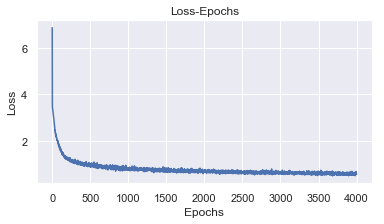

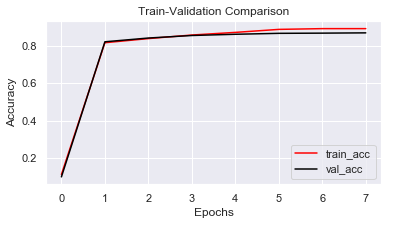

In [26]:
#Plot the Loss-Epochs Change
plt.subplots(figsize = (6, 3))
plt.plot(loss_list)
plt.title('Loss-Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('Loss.jpg', dpi=100, bbox_inches='tight')
plt.show()
#Plot the Accuracy-Epochs Change
plt.subplots(figsize = (6, 3))
plt.plot(accuracy_train,label = 'train_acc',color = 'red')
plt.plot(accuracy_val,label = 'val_acc', color = 'black')
plt.title('Train-Validation Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.savefig('Accuracy.jpg', dpi=100, bbox_inches='tight')
plt.show()

In [27]:
#Show final accuracy on train data
y_train_pred = classify.predict(X)
accuracy_train = np.mean(y_train_pred == label)
print ("The train data accuracy is",accuracy_train*100,'%')
#Normalise the testing data
X = np.reshape(data_predict_all,(-1,784))
X_min = np.min(X,axis=0)
X_max = np.max(X,axis=0)
X = (X-X_min)/(X_max-X_min)
#Predict test data and show accuracy
y_pred = classify.predict(X[:2000,])
accuracy_test = np.mean(y_pred == label_predict)
print ("The test data accuracy is",accuracy_test*100,'%')
y_pred_all = classify.predict(X)
#Save the prediction in h5 form
H = h5py.File("output.h5", "w")
H.create_dataset('label',data=y_pred_all)

The train data accuracy is 89.20333333333333 %
The test data accuracy is 87.55 %


<HDF5 dataset "label": shape (5000,), type "<i8">

In [28]:
#To save space, we don't print the confision matrices
#Produce the confusion matrix for test data
label_predict = list(map(change,label_predict))
y_pred = list(map(change,y_pred))
label_predict = np.array(label_predict,dtype='object')
y_pred = np.array(y_pred,dtype='object')
confusion1 = pd.crosstab(label_predict,y_pred,rownames=['Label'],colnames=['Predictions'])
print(confusion1)
#Produce the confusion matrix for train data
label_predict = list(map(change,label))
y_pred = list(map(change,y_train_pred))
label_predict = np.array(label_predict,dtype='object')
y_pred = np.array(y_pred,dtype='object')
confusion2 = pd.crosstab(label_predict,y_pred,rownames=['Label'],colnames=['Predictions'])
print(confusion2)

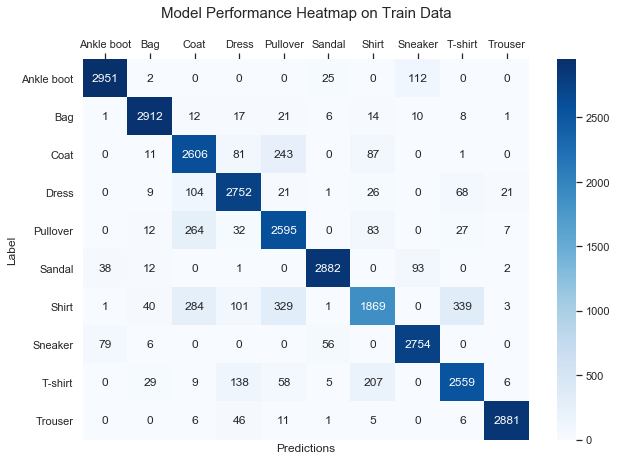

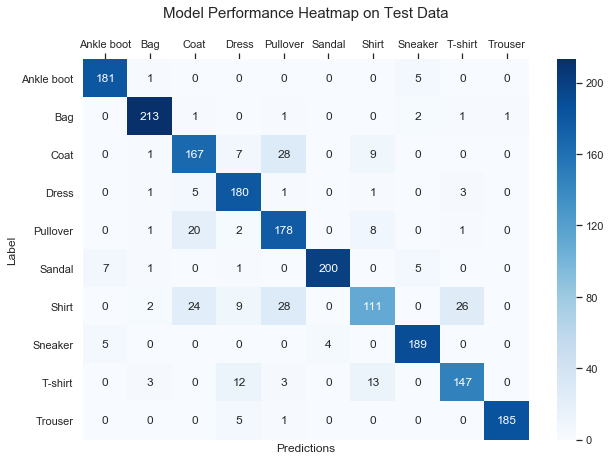

MLP requires 95.67954600000002 s


In [29]:
#Analyse the model
#Visualise the confusion matrix
f1, ax1= plt.subplots(figsize = (10, 7))
ax1.set_title('Model Performance Heatmap on Train Data\n',fontsize=15)
sns.set()
ax1 = sns.heatmap(confusion2,fmt='d',cmap='Blues',annot=True)
ax1.xaxis.tick_top()
f1.savefig('heatmap_train.jpg', dpi=100, bbox_inches='tight')
plt.show()
f2, ax2= plt.subplots(figsize = (10, 7))
ax2.set_title('Model Performance Heatmap on Test Data\n',fontsize=15)
sns.set()
ax2 = sns.heatmap(confusion1,fmt='d',cmap='Blues',annot=True)
ax2.xaxis.tick_top()
f2.savefig('heatmap_test.jpg', dpi=100, bbox_inches='tight')
plt.show()
end = time.process_time() - start
print("MLP requires",end,"s")

0 Times
200 Times
400 Times
600 Times
800 Times
1000 Times
1200 Times
1400 Times
1600 Times
1800 Times
The KNN accuracy is 84.05 %
84.05
2000
2000


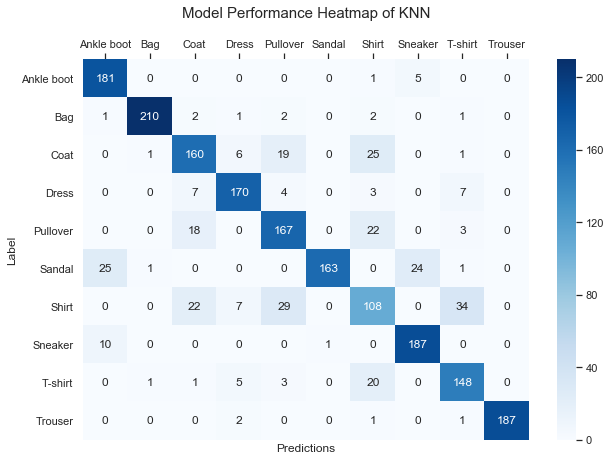

KNN requires 750.4838060000002 s


In [61]:
def KNNClassify(newInput, dataSet, labels, k):
    #KNN model
    #newInput: Test data
    #dataSet: Train data
    #labels: Train label
    numSamples = dataSet.shape[0] 
    #Euclidean distance
    diff = np.tile(newInput, (numSamples, 1)) - dataSet # Subtract element-wise
    squaredDiff = diff ** 2 # squared for the subtract
    squaredDist = np.sum(squaredDiff, axis = 1) # sum is performed by row
    distance = squaredDist ** 0.5
    sortedDistIndices = np.argsort(distance)
    classCount = {} 
    for i in range(k):
        voteLabel = labels[sortedDistIndices[i]]
        classCount[voteLabel] = classCount.get(voteLabel, 0) + 1
    maxCount = 0
    #Find the maximum arg
    for key, value in classCount.items():
        if value > maxCount:
            maxCount = value
            maxIndex = key
    return maxIndex 

if __name__ =="__main__":
    start = time.process_time()
    group = np.reshape(data,(-1,784))
    data_predict = np.reshape(data_predict_all,(-1,784))[:2000,]
    numTestSamples = data_predict.shape[0]
    matchCount = 0
    data_predict_all = []
    #Predict the test data using the return value of KNNClassify
    for i in range(numTestSamples):
        predict = KNNClassify(data_predict[i],group,label,5)
        data_predict_all.append(predict)
        if predict == label_predict[i]:
            matchCount += 1
        #Check the process
        if i % 200 == 0:
            print(i,'Times')
    accuracy = float(matchCount) / numTestSamples
    print ('The KNN accuracy is',accuracy*100,'%')
    print(accuracy*100)
    #Confusion Matrix Generation
    data_predict_all = np.array(data_predict_all)
    label_predict = list(map(change,label_predict))
    y_pred = list(map(change,data_predict_all))
    label_predict = np.array(label_predict,dtype='object')
    y_pred = np.array(y_pred,dtype='object')
    print(len(label_predict))
    print(len(y_pred))
    confusion1 = pd.crosstab(label_predict,y_pred,rownames=['Label'],colnames=['Predictions'])
    #Visualise the confusion matrix
    f1, ax1= plt.subplots(figsize = (10, 7))
    ax1.set_title('Model Performance Heatmap of KNN\n',fontsize=15)
    sns.set()
    ax1 = sns.heatmap(confusion1,fmt='d',cmap='Blues',annot=True)
    ax1.xaxis.tick_top()
    #f1.savefig('KNN heatmap.jpg', dpi=100, bbox_inches='tight')
    plt.show()
    end = time.process_time()-start
    print ('KNN requires', end,'s')

In [ ]:
def Evaluate_MLP(X_train,y_train_label,y_train,X_val,y_val,mode='learning_rate'):
    #Evaluate the MLP performance with different parameter values
    #Generate and return the Loss and Accuracy on train dataset
    print(mode)
    #Possible values
    learning_rates = [0.2,0.3,0.4,0.5,0.6]
    epochs = [2500,3000,3500,4000,4500]
    batch_size = [250,500,750,1000,1250]
    cells = [16,32,64,128,256]
    lambda_ = [0.1,0.01,0.001,0.0001,0.00001]
    loss_list = []
    accuracy_train = []
    if mode == 'learning_rate':
        for i in learning_rates:
            classify = NeuralNetwork(X.shape[1],128,10)
            loss,accuracy1,accuracy2 = classify.train(X_train,y_train_label,y_train,X_val,y_val,learn_rate=i)
            loss_list.append(loss)
            accuracy_train.append(accuracy1)
            y_pred = classify.predict(X[:2000,])
            #Print the test accuracy to be compared
            print(np.mean(y_pred == label_predict))
        return loss_list, accuracy_train
    elif mode == 'epoch':
        for i in epochs:
            classify = NeuralNetwork(X.shape[1],128,10)
            loss,accuracy1,accuracy2 = classify.train(X_train,y_train_label,y_train,X_val,y_val,epoch=i)
            loss_list.append(loss)
            accuracy_train.append(accuracy1)
            y_pred = classify.predict(X[:2000,])
            print(np.mean(y_pred == label_predict))
        return loss_list, accuracy_train
    elif mode == 'batch size':
        for i in batch_size:
            classify = NeuralNetwork(X.shape[1],128,10)
            loss,accuracy1,accuracy2 = classify.train(X_train,y_train_label,y_train,X_val,y_val,batch_size=i)
            loss_list.append(loss)
            accuracy_train.append(accuracy1)
            y_pred = classify.predict(X[:2000,])
            print(np.mean(y_pred == label_predict))
        return loss_list, accuracy_train
    elif mode == 'cell':
        for i in cells:
            classify = NeuralNetwork(X.shape[1],i,10)
            loss,accuracy1,accuracy2 = classify.train(X_train,y_train_label,y_train,X_val,y_val)
            loss_list.append(loss)
            accuracy_train.append(accuracy1)
            y_pred = classify.predict(X[:2000,])
            print(np.mean(y_pred == label_predict))
        return loss_list, accuracy_train
    elif mode == 'lambda':
        for i in lambda_:
            classify = NeuralNetwork(X.shape[1],128,10)
            loss,accuracy1,accuracy2 = classify.train(X_train,y_train_label,y_train,X_val,y_val,lambda_=i)
            loss_list.append(loss)
            accuracy_train.append(accuracy1)
            y_pred = classify.predict(X[:2000,])
            print(np.mean(y_pred == label_predict))
        return loss_list, accuracy_train

In [193]:
#Since the outout is too long, we only run one Evaluate_MLP at one time
loss_list1, accuracy_train1 = Evaluate_MLP(X_train,y_train_label,y_train,X_val,y_val,mode='learning_rate')
loss_list2, accuracy_train2 = Evaluate_MLP(X_train,y_train_label,y_train,X_val,y_val,mode='epoch')
loss_list3, accuracy_train3 = Evaluate_MLP(X_train,y_train_label,y_train,X_val,y_val,mode='batch size')
loss_list4, accuracy_train4 = Evaluate_MLP(X_train,y_train_label,y_train,X_val,y_val,mode='cell')
loss_list5, accuracy_train5 = Evaluate_MLP(X_train,y_train_label,y_train,X_val,y_val,mode='lambda')

batch size
i=0,loss=6.889379,train_acc=0.148000,val_acc=0.101000
i=500,loss=0.982873,train_acc=0.852000,val_acc=0.818000
i=1000,loss=0.854729,train_acc=0.836000,val_acc=0.828500
i=1500,loss=0.648345,train_acc=0.912000,val_acc=0.852500
i=2000,loss=0.661502,train_acc=0.888000,val_acc=0.856500
i=2500,loss=0.679944,train_acc=0.892000,val_acc=0.861500
i=3000,loss=0.649592,train_acc=0.860000,val_acc=0.865500
i=3500,loss=0.620561,train_acc=0.888000,val_acc=0.869500
0.866
i=0,loss=6.885288,train_acc=0.128000,val_acc=0.101000
i=500,loss=1.028224,train_acc=0.806000,val_acc=0.820000
i=1000,loss=0.763981,train_acc=0.854000,val_acc=0.850000
i=1500,loss=0.719204,train_acc=0.858000,val_acc=0.855500
i=2000,loss=0.661317,train_acc=0.870000,val_acc=0.856500
i=2500,loss=0.608652,train_acc=0.912000,val_acc=0.867000
i=3000,loss=0.579460,train_acc=0.888000,val_acc=0.862500
i=3500,loss=0.517737,train_acc=0.916000,val_acc=0.863500
0.873
i=0,loss=6.885070,train_acc=0.121333,val_acc=0.101000
i=500,loss=0.828850

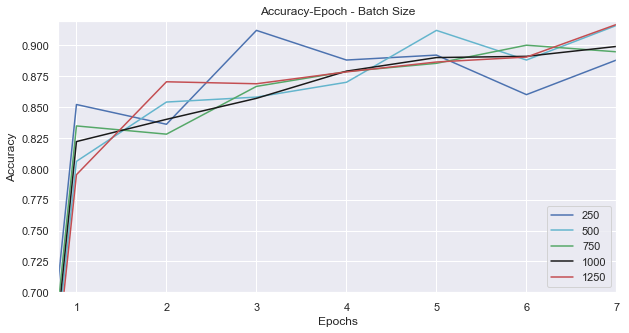

In [194]:
def Visualisation(loss_list,accuracy_train,accuracy_validation=[],mode='learning_rate'):
    #Generate the visualisation of train accuracy with different parameter values
    #Curve Labels
    learning_rates = [0.2,0.3,0.4,0.5,0.6,0.7]
    epochs = [2500,3000,3500,4000,4500]
    batch_size = [250,500,750,1000,1250]
    cells = [16,32,64,128,256]
    lambda_ = [0.1,0.01,0.001,0.0001,0.00001]
    colors = ['b','c','g','k','r','y']
    if len(accuracy_validation)==0:
        plt.subplots(figsize = (10, 5))
        #Use plt.axis to emphasise the details of the pictures
        #plt.axis([0.8, 7, 0.7, 0.92])
        for i in range(len(loss_list)):
            if mode == 'learning_rate':
                plt.plot(accuracy_train[i],color=colors[i],linewidth=1.5,label=learning_rates[i])
            elif mode == 'batch size':
                plt.plot(accuracy_train[i],color=colors[i],linewidth=1.5,label=batch_size[i])
            elif mode == 'cell':
                plt.plot(accuracy_train[i],color=colors[i],linewidth=1.5,label=cells[i])
            elif mode == 'lambda':
                plt.plot(accuracy_train[i],color=colors[i],linewidth=1.5,label=lambda_[i])
        plt.title('Accuracy-Epoch - Batch Size')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc = 'lower right')
        #plt.savefig('Accuracy_Evaluation3.jpg', dpi=100, bbox_inches='tight')
        plt.show()
#To save pictures, each time we only run one parameter evaluation
Visualisation(loss_list1,accuracy_train1,mode='learning_rate')
Visualisation(loss_list3,accuracy_train3,mode='batch size')
Visualisation(loss_list4,accuracy_train4,mode='cell')
Visualisation(loss_list5,accuracy_train5,mode='lambda')

In [67]:
def KNN(k,data_predict_all):
    #Run KNN code with different k value and generate time and accuracy
    start = time.process_time()
    print('Start')
    group = np.reshape(data,(-1,784))
    data_predict = np.reshape(data_predict_all,(-1,784))[:2000,]
    numTestSamples = data_predict.shape[0]
    matchCount = 0
    data_predict_all = []
    for i in range(numTestSamples):
        predict = KNNClassify(data_predict[i],group,label,k)
        data_predict_all.append(predict)
        if predict == label_predict[i]:
            matchCount += 1
    accuracy = float(matchCount) / numTestSamples
    print ('The KNN accuracy is',accuracy*100,'%')
    print(accuracy*100,'%')
    print('End')
    end = time.process_time() - start
    print(end,'s')
#k value list
k = [4,5,7,8,10]
for i in k:
    KNN(i,data_predict_all)

Start
The KNN accuracy is 84.0 %
84.0 %
End
707.1388630000001 s
Start
The KNN accuracy is 84.05 %
84.05 %
End
713.2284209999998 s
Start
The KNN accuracy is 83.89999999999999 %
83.89999999999999 %
End
686.2981900000004 s
Start
The KNN accuracy is 84.0 %
84.0 %
End
712.1368010000006 s
Start
The KNN accuracy is 84.0 %
84.0 %
End
700.487833000001 s
